In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime as dt

from tools import make_track, make_ER, kalman_filter, ols_regression, lasso_regression, ridge_regression, ml_kalman_filter,\
    replication_stats, ml_kalman_filter2
from hc_graph import hc_stock
sns.set()

In [3]:
prices = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True,
                     dayfirst=True)[['BNPIFEU','BNPIFE10',"SPGSGCP","BPFXCAD1"]]
#prices_risk_premia = pd.read_csv(r"financial_data/bnp_risk_premia_data.csv", index_col=0, parse_dates=True, 
#                                 dayfirst=True)[["BNPIMDEA"]]


#prices = pd.concat([prices_index, prices_risk_premia],axis=1).dropna()
returns = prices.pct_change().dropna()

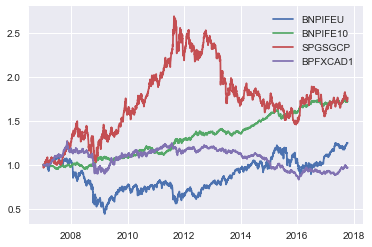

In [4]:
(prices/prices.iloc[0]).plot()

In [5]:
returns.corr(method="pearson")

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
BNPIFEU,1.000000,-0.472742,0.005528,0.477899
BNPIFE10,-0.472742,1.000000,0.096560,-0.247564
SPGSGCP,0.005528,0.096560,1.000000,0.282960
BPFXCAD1,0.477899,-0.247564,0.282960,1.000000


In [6]:
# n_reweight = 300
# reweight_cal = returns.sample(n_reweight).sort_index().index
# df_reweight = pd.DataFrame(index=reweight_cal, data= np.random.normal(0.3,0.2,
#                            size=(n_reweight,len(prices.columns))), columns=prices.columns)
# df_reweight.to_pickle("df_reweight2.pkl")

df_reweight = pd.read_pickle("df_reweight2.pkl")

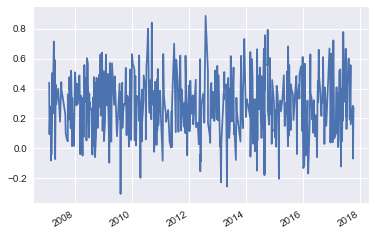

In [7]:
df_reweight['BNPIFEU'].plot()

In [8]:
df_reweight.head()

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
2007-01-29,0.438720,0.176435,0.116390,0.287326
2007-02-02,0.094326,0.542737,0.036040,0.573398
2007-02-07,0.203538,0.286680,0.247430,0.063441
2007-02-20,0.227404,0.114769,0.965287,0.508066
2007-02-21,-0.081782,0.174380,0.597206,0.250860


In [9]:
prices_for_track = prices.loc[df_reweight.index[0]:]
track = make_track(prices_for_track, df_reweight, lag=0).rename(columns={'Track':'$Dynamic\ Portfolio$'})

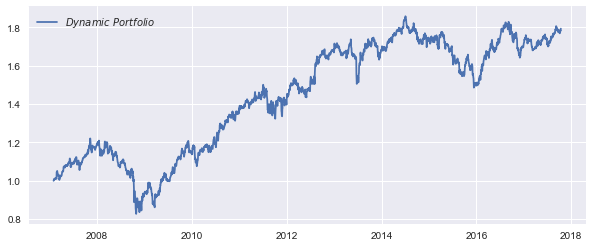

In [10]:
track.plot(figsize=(10,4))

In [11]:
## Replication Data

track_returns = track.pct_change().dropna()
universe_returns = returns.loc[track_returns.index]

freq = 5

In [58]:
%%time
df_res = track.loc['2008':].copy()
for size in [5, 10, 30, 60]:
    df_weight_ols = ols_regression(track_returns, universe_returns, size, freq)
    prices_for_track = prices.loc[df_weight_ols.index[0]:]
    replication = make_track(prices_for_track, df_weight_ols)

    df_res["$OLS\ {}\ day\ lookback$".format(size)] = replication.loc[df_res.index]

Wall time: 17.2 s


In [13]:
#df_weight_ridge = ridge_regression(vol_cap_returns, universe_returns, size, freq,l=5e-5)
#prices_for_track = prices.loc[df_weight_ridge.index[0]:]
#replication_ridge = make_track(prices_for_track, df_weight_ridge)
#
#df_res["Ridge"] = replication_ridge.loc[df_res.index]
#df_res = df_res/df_res.iloc[0]

In [14]:
#%%time
#df_weight_lasso = lasso_regression(vol_cap_returns, universe_returns, size, freq,l=5e-6)
#prices_for_track = prices.loc[df_weight_lasso.index[0]:]
#replication_lasso = make_track(prices_for_track, df_weight_lasso)
#
#df_res["Lasso"] = replication_lasso.loc[df_res.index]
#df_res = df_res/df_res.iloc[0]

In [59]:
%%time

for nu in [0.0025, 0.005, 0.0075, 0.01, 0.02, 0.2]:
    
    df_weight_kalman = kalman_filter(track_returns, universe_returns, freq, sigma_weight=1., sigma_return=nu)

    prices_for_track_kalman = prices.loc[df_weight_kalman.index[0]:]
    replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_res.index[0]:]
    df_res["$Kalman\ \\nu={}$".format(nu)] = replication_kalman

Wall time: 27 s


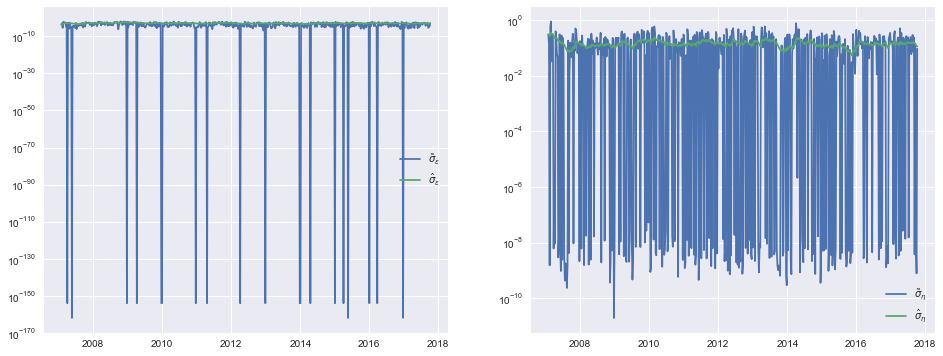

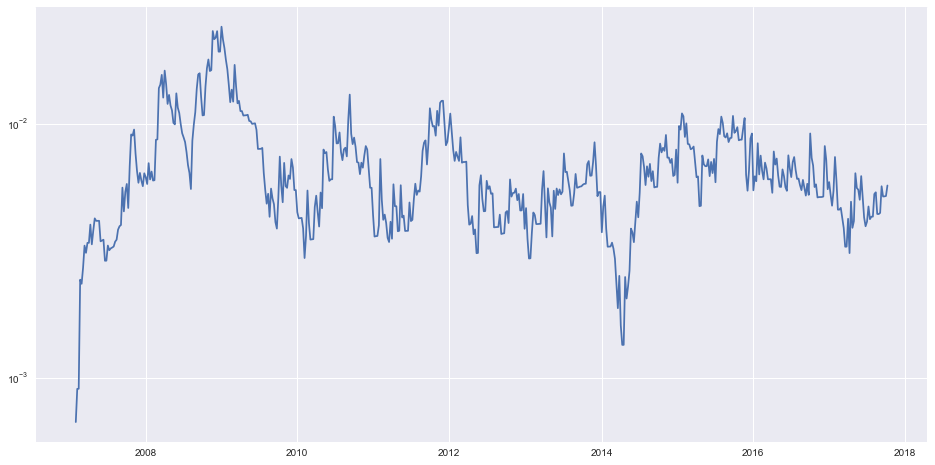

Wall time: 15.1 s


In [68]:
%%time
df_weight_ml_kalman, df_sigma = ml_kalman_filter(track_returns, universe_returns, freq, tau=0.1, plot_sigma=True)

prices_for_track_kalman_ml = prices.loc[df_weight_ml_kalman.index[0]:]
replication_kalman_ml = make_track(prices_for_track_kalman_ml, df_weight_ml_kalman).loc[df_res.index[0]:]
df_res["$ML\ Kalman$"] = replication_kalman_ml

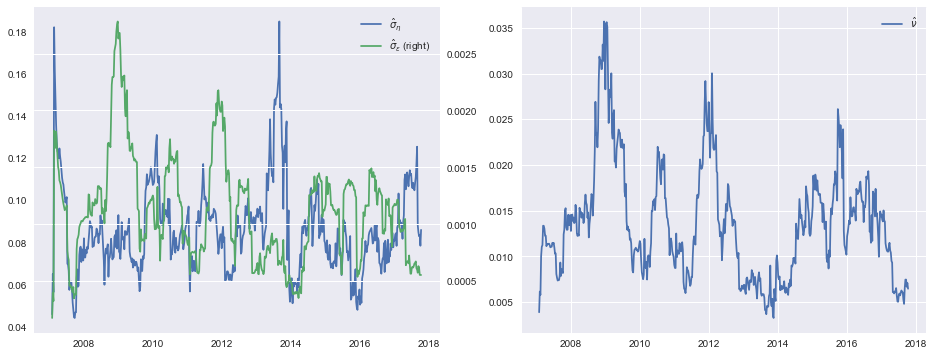

Wall time: 1h 32min 51s


In [78]:
%%time
df_weight_ml_kalman2, df_sigma2 = ml_kalman_filter2(track_returns, universe_returns, freq, mle_period=20, plot_sigma=True)

prices_for_track_kalman_ml2 = prices.loc[df_weight_ml_kalman2.index[0]:]
replication_kalman_ml2 = make_track(prices_for_track_kalman_ml2, df_weight_ml_kalman2).loc[df_res.index[0]:]
df_res["$ML\ Kalman\ 2$"] = replication_kalman_ml2

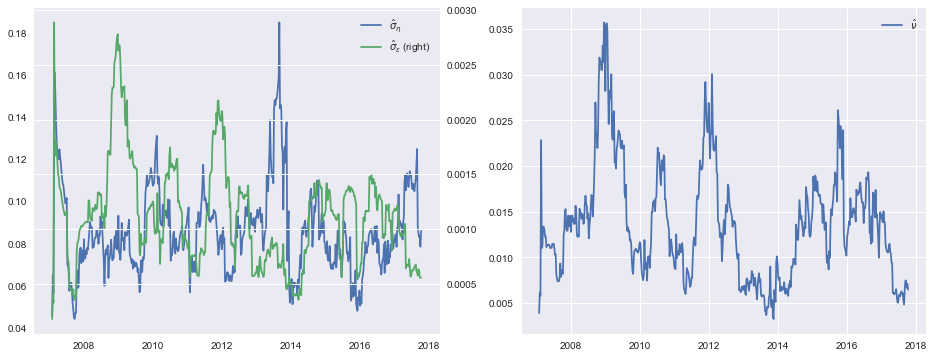

Wall time: 1h 37min 44s


In [93]:
%%time
df_weight_ml_kalman2, df_sigma2 = ml_kalman_filter2(track_returns, universe_returns, freq, mle_period=20, plot_sigma=True)

prices_for_track_kalman_ml2 = prices.loc[df_weight_ml_kalman2.index[0]:]
replication_kalman_ml2 = make_track(prices_for_track_kalman_ml2, df_weight_ml_kalman2).loc[df_res.index[0]:]
df_res["$ML\ Kalman\ 2$"] = replication_kalman_ml2

In [79]:
df_res = df_res / df_res.iloc[0]

In [80]:
df_res.head()

,$Dynamic\ Portfolio$,$OLS\ 5\ day\ lookback$,$OLS\ 10\ day\ lookback$,$OLS\ 30\ day\ lookback$,$OLS\ 60\ day\ lookback$,$Kalman\ \nu=0.0025$,$Kalman\ \nu=0.005$,$Kalman\ \nu=0.0075$,$Kalman\ \nu=0.01$,$Kalman\ \nu=0.02$,$Kalman\ \nu=0.2$,$ML\ Kalman$,$ML\ Kalman\ 2$
2008-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-02,1.004662,1.001986,1.005785,1.005786,1.003543,1.004627,1.005602,1.005673,1.005498,1.004787,1.003680,1.005723,1.005126
2008-01-03,1.008286,1.004981,1.009792,1.010024,1.008252,1.008208,1.009440,1.009573,1.009399,1.008603,1.007637,1.009613,1.008993
2008-01-04,0.999712,0.997827,1.007272,1.005781,1.002020,1.003923,1.006328,1.006727,1.006546,1.005374,1.002058,1.006713,1.005982
2008-01-07,0.997832,0.998469,1.005860,1.004398,1.000449,1.003239,1.005121,1.005365,1.005139,1.004045,1.000446,1.005413,1.004576


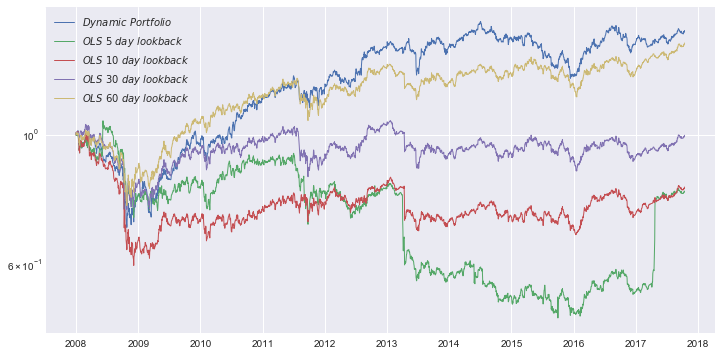

In [81]:
df_res[["$Dynamic\ Portfolio$","$OLS\ 5\ day\ lookback$", "$OLS\ 10\ day\ lookback$", "$OLS\ 30\ day\ lookback$",
        "$OLS\ 60\ day\ lookback$"]].plot(figsize=(12,6),linewidth=1, logy=True)

In [82]:
g = hc_stock(df_res)
g.plot()

In [83]:
df_stat = replication_stats(df_res, fund_name='$Dynamic\ Portfolio$')
df_stat

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
$Dynamic\ Portfolio$,0.000000,1.000000,0.395365,0.041300,1.000000,1.000000
$OLS\ 5\ day\ lookback$,0.008191,-0.156997,-0.055623,-0.021597,0.606096,0.579520
$OLS\ 10\ day\ lookback$,0.005488,0.480660,-0.097542,-0.020062,0.751630,0.624491
$OLS\ 30\ day\ lookback$,0.004571,0.639720,0.055967,-0.000186,0.812004,0.655400
$OLS\ 60\ day\ lookback$,0.004390,0.667633,0.381094,0.036244,0.821160,0.666304
$Kalman\ \nu=0.0025$,0.005344,0.507456,-0.106532,-0.021205,0.765097,0.633019
$Kalman\ \nu=0.005$,0.005113,0.549161,-0.084518,-0.018006,0.780418,0.649669
$Kalman\ \nu=0.0075$,0.004996,0.569521,-0.059505,-0.014729,0.787998,0.658901
$Kalman\ \nu=0.01$,0.004918,0.582814,-0.040297,-0.012256,0.792913,0.663878
$Kalman\ \nu=0.02$,0.004734,0.613510,0.003262,-0.006706,0.804169,0.672234
